In [47]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Load the dataset (replace 'path_to_your_data.csv' with your actual file path)
df = pd.read_csv('C:/Users/Administrator/Documents/kifiya/Week_6/df_woe.csv')
df = df.drop(columns=['CustomerId', 'TransactionId','SubscriptionId','AccountId','ProductId','BatchId','TransactionStartTime','CurrencyCode'])
print(df.columns)

Index(['TransactionYear', 'Value', 'ChannelId_woe', 'TransactionAmountStd',
       'AverageTransactionAmount', 'TotalTransactionAmount', 'RiskLabel',
       'TransactionDay', 'FraudResult', 'TransactionCount', 'TransactionHour',
       'Amount', 'ProductCategory_woe', 'CountryCode', 'ProviderId_woe',
       'TransactionMonth', 'RFMS_Score', 'PricingStrategy', 'Monetary_woe',
       'Seniority_woe', 'Frequency_woe', 'Recency_woe'],
      dtype='object')


In [31]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the risklabel column
df['RiskLabel'] = label_encoder.fit_transform(df['RiskLabel'])


# Split data into features (X) and target variable (y)
X = df.drop(columns=['FraudResult','RiskLabel'])  # Features
y = df['RiskLabel']  # Target variable

# Split the data: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)

# Train the models
rf_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)

print("Training completed for both Random Forest and Gradient Boosting models.")

Training completed for both Random Forest and Gradient Boosting models.


In [33]:
# Random Forest Parameter Grid
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid_search.best_params_)

# Gradient Boosting Parameter Grid
gbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Search for Gradient Boosting
gbm_random_search = RandomizedSearchCV(estimator=gbm_model, param_distributions=gbm_param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, verbose=2)
gbm_random_search.fit(X_train, y_train)

print("Best GBM Parameters:", gbm_random_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GBM Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.01}


In [50]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return roc_auc

# Evaluate Random Forest
print("Random Forest Performance:")
rf_roc_auc = evaluate_model(rf_model, X_test, y_test)

# Evaluate Gradient Boosting
print("\nGradient Boosting Performance:")
gbm_roc_auc = evaluate_model(gbm_model, X_test, y_test)

cv_scores_rf = cross_val_score(rf_model, X, y, cv=5)
cv_scores_gbm = cross_val_score(gbm_model, X, y, cv=5)
print("\n")
print("Random Forest CV Average Score:", cv_scores_rf.mean())
print("GBM CV Average Score:", cv_scores_gbm.mean())

Random Forest Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000

Gradient Boosting Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000


Random Forest CV Average Score: 1.0
GBM CV Average Score: 1.0


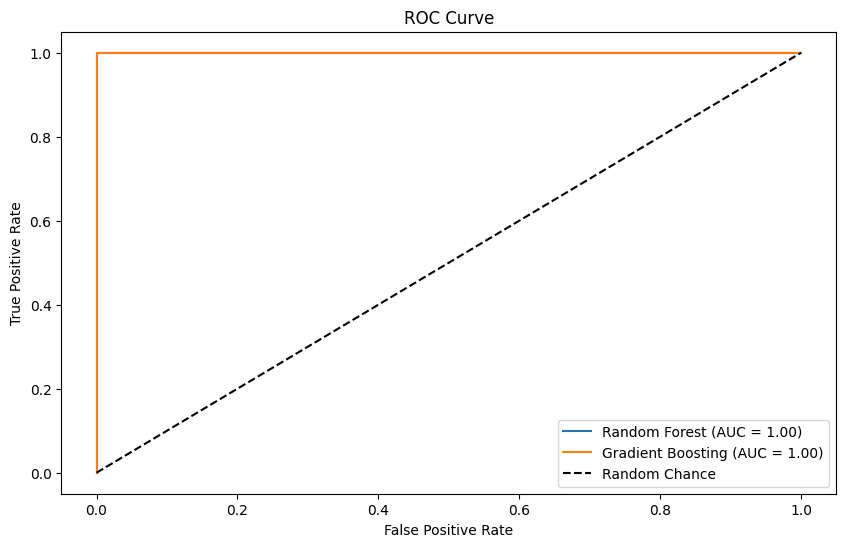

In [35]:
# Plot ROC Curve for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, gbm_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot(fpr_gbm, tpr_gbm, label=f'Gradient Boosting (AUC = {gbm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
